In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

## Functions

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def time_and_memory_per_connection(df):
    df = time_per_connection(df)
    df = memory_per_connection(df)
    return df

In [6]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Creation Time \n per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Exchange Time \n per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    return df

In [7]:
def memory_per_connection(df):
    df['Memory per connection'] = (df['VSize_ini_sum'] - df['VSize_nodes_sum']) / df['N_conns_sum'] * 1024
    df['Total Mem. per Conn.'] = df['VSize_mem_sum'] / df['N_conns_sum'] * 1024
    return df

In [8]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

## Benchmarks with weak scaling

### HPC Benchmark

,git,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,num_tasks,NUM_VPS,SCALE,PLASTIC,T_nrns,T_conns_min,...,T_bld_nx,Conn. Total,Conn. Creation (min),Conn. Exchange (min),N_VP,connections,ini,other,Memory per VP,Simulation time
0,GIT: (heads/v2.20.0@37722d5e3),1,6,6,6,36,20,True,0.43,47.68,...,103.00,103.00,47.68,51.32,36,2.739827,0.021162,0.059665,2.820655,192.68
1,GIT: (heads/v2.20.0@37722d5e3),2,6,6,12,72,40,True,0.56,47.57,...,105.09,105.09,47.57,53.47,72,2.739827,0.030765,0.063015,2.833607,196.22
2,GIT: (heads/v2.20.0@37722d5e3),4,6,6,24,144,80,True,0.58,47.40,...,109.11,109.11,47.40,57.45,144,2.739827,0.109256,0.059372,2.908456,202.64
3,GIT: (heads/v2.20.0@37722d5e3),8,6,6,48,288,160,True,0.46,47.50,...,114.50,114.46,47.50,62.89,288,2.739827,0.114920,0.059384,2.914131,213.17
4,GIT: (heads/v2.20.0@37722d5e3),16,6,6,96,576,320,True,0.59,47.41,...,131.12,131.11,47.41,79.59,576,2.739827,0.262408,0.060606,3.062841,229.50
5,GIT: (heads/v2.20.0@37722d5e3),32,6,6,192,1152,640,True,0.98,47.54,...,157.42,157.42,47.54,105.64,1152,2.739827,0.592676,0.060439,3.392943,266.72
0,GIT: (master@630a97265),1,6,6,6,36,20,True,0.57,52.60,...,146.31,146.30,52.60,86.56,36,2.735677,0.011396,0.138224,2.885298,200.26
1,GIT: (master@630a97265),2,6,6,12,72,40,True,0.48,52.62,...,147.15,147.14,52.62,89.53,72,2.734538,0.019128,0.138915,2.892580,206.66
2,GIT: (master@630a97265),4,6,6,24,144,80,True,0.60,52.97,...,151.71,151.71,52.97,92.05,144,2.734538,0.106367,0.136086,2.976991,209.80
3,GIT: (master@630a97265),8,6,6,48,288,160,True,0.52,53.34,...,158.56,158.56,53.34,98.38,288,2.734538,0.113821,0.136098,2.984457,221.25


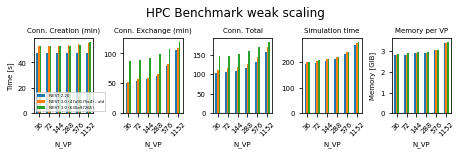

In [42]:
hpc_220 = pd.read_csv('results/hpc_benchmark_v2.20.0@37722d5e3_daint.csv')
hpc_220['Case'] = ['NEST 2.20'] * len(hpc_220)
hpc_3 = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint.csv')
hpc_3['Case'] = ['NEST 3.0 (630a97265)'] * len(hpc_3)

hpc_3_old = pd.read_csv('results/hpc_benchmark_3_0_47a9175e4_daint.csv')
hpc_3_old['Case'] = ['NEST 3.0 (47a9175e4) - old'] * len(hpc_3_old)

hpc = pd.concat([hpc_220, hpc_3, hpc_3_old])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.pdf', legend_loc='lower left',
                     title='HPC Benchmark weak scaling')

# hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.svg', legend_loc='lower left',
#                      title='HPC Benchmark weak scaling')

hpc

### HPC - `fixed_outdegree`

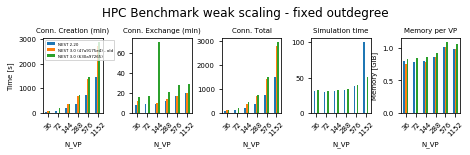

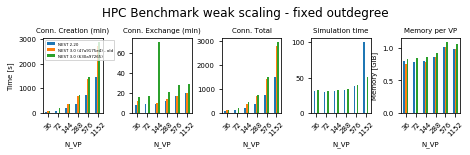

In [54]:
hpc_2_20_out = pd.read_csv('results/hpc_benchmark_2_20_37722d5e3_daint_out.csv')
hpc_2_20_out['Case'] = ['NEST 2.20']*len(hpc_2_20_out)

hpc_3_out = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_out.csv')
hpc_3_out['Case'] = ['NEST 3.0 (630a97265)']*len(hpc_3_out)

hpc_3_out_old = pd.read_csv('results/hpc_benchmark_3_0_47a9175e4_daint_out.csv')
hpc_3_out_old['Case'] = ['NEST 3.0 (47a9175e4) - old']*len(hpc_3_out_old)

hpc_out = pd.concat([hpc_2_20_out, hpc_3_out, hpc_3_out_old])

hpc_out = calculate_T_conn_and_memory(hpc_out)
hpc_out_p = plot_compare(hpc_out, 'figures/hpc_benchmark_weak_scaling_out.pdf', legend_loc='upper left',
                         title='HPC Benchmark weak scaling - fixed outdegree')

hpc_out_p = plot_compare(hpc_out, 'figures/hpc_benchmark_weak_scaling_out.svg', legend_loc='upper left',
                         title='HPC Benchmark weak scaling - fixed outdegree')

### HPC - Rules

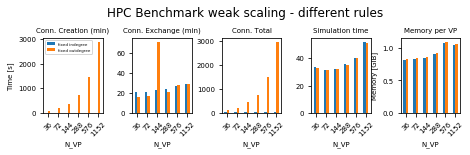

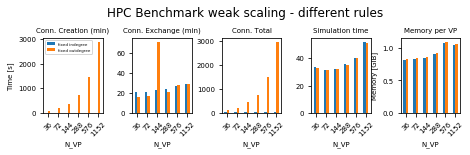

In [53]:
hpc_3_in = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_in.csv')
hpc_3_in['Case'] = ['fixed indegree']*len(hpc_3_in)

hpc_3_out = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_out.csv')
hpc_3_out['Case'] = ['fixed outdegree']*len(hpc_3_out)

hpc_rules = pd.concat([hpc_3_in, hpc_3_out])


hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules_p = plot_compare(hpc_rules, 'figures/hpc_benchmark_weak_scaling_rules.pdf', legend_loc='upper left',
                           title='HPC Benchmark weak scaling - different rules')

hpc_rules_p = plot_compare(hpc_rules, 'figures/hpc_benchmark_weak_scaling_rules.svg', legend_loc='upper left',
                           title='HPC Benchmark weak scaling - different rules')

### Population model

Conn. Creation (min)                                                  \
Case            NEST 2.20 NEST 3.0 (630a97265) NEST 3.0 (630a97265) - old   
N_VP                                                                        
36              71.352708            57.778814                  57.905697   
72             100.998181            69.362128                  69.335492   
144            158.170904            90.439362                  89.550997   
288            263.136210           132.407036                 130.736555   
576                   NaN                  NaN                        NaN   
1152                  NaN                  NaN                        NaN   

     Conn. Exchange (min)                                                  \
Case            NEST 2.20 NEST 3.0 (630a97265) NEST 3.0 (630a97265) - old   
N_VP                                                                        
36              46.780410            76.824877                  45.578337   
72              48.349137            77.148675                  47.704243   
144             50.818773            81.855925                  51.191208   
288             59.571098            90.679201                  61.675069   
576                   NaN                  NaN                        NaN   
1152                  NaN                  NaN                        NaN   

     Conn. Total                                                  \
Case   NEST 2.20 NEST 3.0 (630a97265) NEST 3.0 (630a97265) - old   
N_VP                                                               
36    122.697226           134.889175                 113.009834   
72    153.851235           147.075606                 126.176039   
144   214.495860           174.418358                 149.590930   
288   329.935652           230.149506                 206.636241   
576          NaN                  NaN                        NaN   
1152         NaN                  NaN                        NaN   

     Memory per VP                                                    T_nrns  \
Case     NEST 2.20 NEST 3.0 (630a97265) NEST 3.0 (630a97265) - old NEST 2.20   
N_VP                                                                           
36        3.437732             3.533765                   3.456075  0.379886   
72        3.508745             3.639517                   3.561793  0.827344   
144       3.737454             3.837888                   3.781858  0.636039   
288       3.519215             3.632609                   3.554878  0.951179   
576            NaN                  NaN                        NaN       NaN   
1152           NaN                  NaN                        NaN       NaN   

                                                      
Case NEST 3.0 (630a97265) NEST 3.0 (630a97265) - old  
N_VP                                                  
36               0.220223                   0.131594  
72               0.237714                   0.075080  
144              0.485208                   0.106480  
288              0.393870                   0.170175  
576                   NaN                        NaN  
1152                  NaN                        NaN

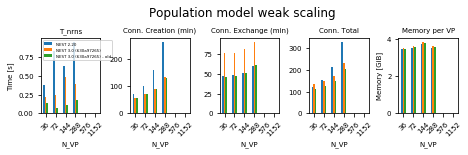

In [43]:
population_2_20 = pd.read_csv('results/population_model_2_20_37722d5e3_daint_in.csv')
population_2_20['Case'] = ['NEST 2.20'] * len(population_2_20)
population_3 = pd.read_csv('results/population_model_3_0_630a97265_daint_in.csv')
population_3['Case'] = ['NEST 3.0 (630a97265)'] * len(population_3)

population_3_old = pd.read_csv('results/population_model_3_0_47a9175e4_daint_in.csv')
population_3_old['Case'] = ['NEST 3.0 (630a97265) - old'] * len(population_3_old)

population = pd.concat([population_2_20, population_3, population_3_old])

population = calculate_T_conn_and_memory(population)
population_p = plot_compare(population, 'figures/population_model_weak_scaling.pdf',
                            ['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                             'Memory per VP'],
                            plot_T_sim=False, legend_loc='upper left',
                            title='Population model weak scaling')

population_p

### Population model - start with scale=4

Conn. Creation (min)                                                  \
Case            NEST 2.20 NEST 3.0 (47a9175e4) - old NEST 3.0 (630a97265)   
N_VP                                                                        
36              45.332983                  36.955057            36.914895   
72              80.451655                  55.495401            55.437133   
144            126.068755                  72.194067            72.418309   
288            210.201287                 104.732111           105.944226   
576            396.802894                 173.740939           175.891819   
1152           763.592566                 309.285594           313.015464   

     Conn. Exchange (min)                                                  \
Case            NEST 2.20 NEST 3.0 (47a9175e4) - old NEST 3.0 (630a97265)   
N_VP                                                                        
36              29.345186                  29.071780            49.467187   
72              38.265924                  37.857497            62.666225   
144             41.133215                  41.669640            66.852567   
288             48.099635                  47.426490            73.172008   
576             64.053706                  64.363408            83.776987   
1152            94.555175                  92.295056            96.509678   

     Conn. Total                                                  \
Case   NEST 2.20 NEST 3.0 (47a9175e4) - old NEST 3.0 (630a97265)   
N_VP                                                               
36     77.963455                  71.925418            86.805659   
72    122.550333                 100.845343           118.966466   
144   171.757519                 122.426312           141.050577   
288   264.531648                 160.873778           181.926299   
576   471.992790                 247.792988           268.772479   
1152  880.145318                 424.864993           420.893548   

     Memory per VP                                                  
Case     NEST 2.20 NEST 3.0 (47a9175e4) - old NEST 3.0 (630a97265)  
N_VP                                                                
36        2.222359                   2.236429             2.323058  
72        2.927504                   2.953619             3.031350  
144       3.003872                   3.036972             3.114703  
288       2.939354                   3.031440             3.109171  
576       2.998736                   3.031835             3.112170  
1152      3.081466                   3.032537             3.112872

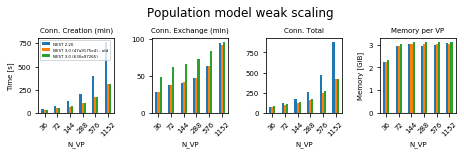

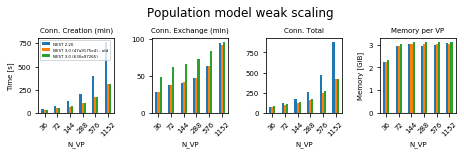

In [47]:
population_s4_220 = pd.read_csv('results/population_model_2_20_37722d5e3_daint_in_scale4.csv')
population_s4_220['Case'] = ['NEST 2.20'] * len(population_s4_220)
population_s4_3 = pd.read_csv('results/population_model_3_0_630a97265_daint_in_scale4.csv')
population_s4_3['Case'] = ['NEST 3.0 (630a97265)'] * len(population_s4_3)

population_s4_3_old = pd.read_csv('results/population_model_3_0_47a9175e4_daint_in_scale4.csv')
population_s4_3_old['Case'] = ['NEST 3.0 (47a9175e4) - old'] * len(population_3_old)

population_s4 = pd.concat([population_s4_220, population_s4_3, population_s4_3_old])

population_s4 = calculate_T_conn_and_memory(population_s4)
population_s4_p = plot_compare(population_s4, 'figures/population_model_weak_scaling_scale4.pdf',
                               ['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                                'Memory per VP'],
                               plot_T_sim=False, legend_loc='upper left',
                               title='Population model weak scaling')

population_s4_p = plot_compare(population_s4, 'figures/population_model_weak_scaling_scale4.svg',
                               ['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                                'Memory per VP'],
                               plot_T_sim=False, legend_loc='upper left',
                               title='Population model weak scaling')

population_s4_p

### Population model - `fixed_outdegree`

0     382.215893
1     661.518434
2    1210.709612
3    2270.137045
4    4397.411327
5            NaN
0     517.505644
1     926.714142
2    1740.919693
3    3344.155159
4            NaN
5            NaN
Name: T_conns_min, dtype: float64
0     396.630207
1     676.281729
2    1266.915778
3    2377.381401
4    5143.177032
5            NaN
0     657.270283
1     945.149023
2    1794.366704
3    3448.692000
4            NaN
5            NaN
Name: T_conns_max, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: T_ini_min, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: T_ini_max, dtype: float64


TypeError: Empty 'DataFrame': no numeric data to plot

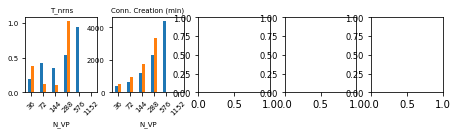

In [35]:
population_out_m = pd.read_csv('results/population_model_02a44ba55_daint_out.csv')
population_out_m['Case'] = ['Master (02a44ba55)'] * len(population_out_m)
population_out_3 = pd.read_csv('results/population_model_3_0_47a9175e4_daint_out.csv')
population_out_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(population_out_3)

population_out = pd.concat([population_out_m, population_out_3])

population_out = calculate_T_conn_and_memory(population_out)

print(population_out['T_conns_min'])
print(population_out['T_conns_max'])
print(population_out['T_ini_min'])
print(population_out['T_ini_max'])
population_out_p = plot_compare(population_out, 'figures/population_model_out_weak_scaling.pdf',
                                ['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                                 'Memory per VP'],
                                plot_T_sim=False, legend_loc='upper left')

population_out_p

### Multi-Area Model

0      60539406
1     121689362
2     242533311
3     485965655
4       5574566
5    1936676440
0      60363069
1     119604230
2     242952584
3     486924029
4       5553407
5    1918935588
Name: N_spks_sum, dtype: int64
0     258258
1     516391
2    1032643
3    2065151
4    4130180
5    8260234
0     258257
1     516390
2    1032642
3    2065150
4    4130179
5    8260233
Name: N_nrns, dtype: int64


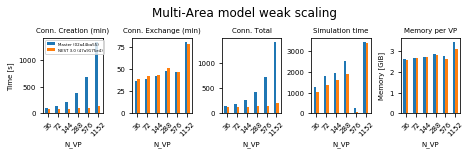

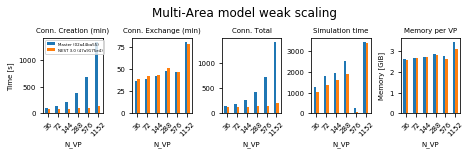

In [9]:
MAM_m = pd.read_csv('results/multi-area_model_02a44ba55_daint.csv')
MAM_m['Case'] = ['Master (02a44ba55)'] * len(MAM_m)
MAM_3 = pd.read_csv('results/multi-area_model_3_0_47a9175e4_daint.csv')
MAM_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(MAM_m)

MAM = pd.concat([MAM_m, MAM_3])

MAM['T_conns_min'] = MAM['T_network_global_min'] + MAM['T_connect_min']
MAM['T_conns_max'] = MAM['T_network_global_max'] + MAM['T_connect_max']

MAM = calculate_T_conn_and_memory(MAM)
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.pdf', legend_loc='upper left',
                     title='Multi-Area model weak scaling')
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.svg', legend_loc='upper left',
                     title='Multi-Area model weak scaling')

# print(MAM['N_spks_sum'])
# print(MAM['N_nrns'])
# print(MAM['N_conns_sum'])

,git,NUMBER_OF_NODES,TASKS_PER_NODE,NUM_VPS,THREADS_PER_TASK,SCALE,NUM_VPS.1,num_tasks,T_network_local,T_network_global_min,...,Conn. Creation (min),Conn. Exchange (min),N_VP,VSize_mem_sum,VSize_nodes_sum,connections,ini,other,Memory per VP,Simulation time
0,GIT: (NEST master@02a44ba55),1,6,36,6,0.0625,36,6,341.724846,57.579290,...,102.219284,36.255836,36,96466320,NaN,NaN,0.061581,NaN,2.617066,1248.481495
1,GIT: (NEST master@02a44ba55),2,6,72,6,0.1250,72,12,347.330095,96.413642,...,141.067416,39.090754,72,193052372,NaN,NaN,0.103871,NaN,2.682427,1796.520609
2,GIT: (NEST master@02a44ba55),4,6,144,6,0.2500,144,24,361.744431,172.468967,...,218.120706,41.850874,144,386074964,NaN,NaN,0.168813,NaN,2.732563,1947.256189
3,GIT: (NEST master@02a44ba55),8,6,288,6,0.5000,288,48,368.250732,323.471307,...,375.658750,48.037352,288,794239156,NaN,NaN,0.253252,NaN,2.883271,2530.915415
4,GIT: (NEST master@02a44ba55),16,6,576,6,1.0000,576,96,379.137986,621.097625,...,681.382079,46.187710,576,1619262644,NaN,NaN,0.101573,NaN,2.782561,266.596577
5,GIT: (NEST master@02a44ba55),32,6,1152,6,2.0000,1152,192,428.092637,1260.013937,...,1340.902400,80.779454,1152,3556620212,NaN,NaN,0.504780,NaN,3.449100,3452.657968
0,GIT: (NEST nest-3@47a9175e4),1,6,36,6,0.0625,36,6,45.833846,32.712802,...,76.993891,38.991091,36,96438952,NaN,NaN,0.035485,NaN,2.590245,1050.472828
1,GIT: (NEST nest-3@47a9175e4),2,6,72,6,0.1250,72,12,47.194375,34.431632,...,78.695629,41.635359,72,193030404,NaN,NaN,0.112389,NaN,2.669169,1364.359476
2,GIT: (NEST nest-3@47a9175e4),4,6,144,6,0.2500,144,24,49.735653,37.911488,...,82.689118,43.824476,144,386096564,NaN,NaN,0.169057,NaN,2.730468,1609.042214
3,GIT: (NEST nest-3@47a9175e4),8,6,288,6,0.5000,288,48,61.402595,44.506323,...,89.890871,50.775665,288,772229356,NaN,NaN,0.282787,NaN,2.839923,1892.577822


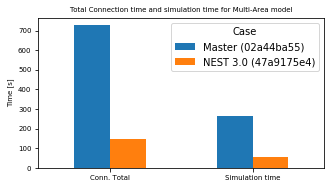

In [14]:
MAM_16 = MAM[MAM['NUMBER_OF_NODES']==16]

values = ['Conn. Total', 'Simulation time']

df_p = pd.pivot_table(MAM_16, columns='Case', values=values)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(cm2inch(13),cm2inch(7)))

df_p.plot(kind='bar', ax = axes, title='Total Connection time and simulation time for Multi-Area model',
          fontsize=fontsize_axis, rot=0)
axes.set_ylabel('Time [s]')

fig.savefig("figures/multi-area_model_original_size_Tconntotal_tsim.pdf", bbox_inches='tight')

fig.savefig("figures/multi-area_model_original_size_Tconntotal_tsim.svg", bbox_inches='tight')

MAM

### Topology model

NB! This is not 4x4!

,git,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,num_tasks,NUM_VPS,SCALE,count,T_nrns,T_conns_max,T_conns_min,VSize_nodes_sum,VSize_mem_sum,VSize_ini_sum,VSize_sum,N_nrns,N_conns_sum,Case,N_VP
0,NaN,1,6,6,6,36,1,NaN,3.348829,113.986795,113.986485,7961280.0,45697728.0,50453304.0,50453304.0,661029.0,6.067075e+08,Master (00e0d3cc8),36
1,NaN,2,6,6,12,72,2,NaN,7.271655,256.673565,256.665625,17810996.0,148293172.0,155750180.0,155750180.0,1321997.0,2.422275e+09,Master (00e0d3cc8),72
2,NaN,4,6,6,24,144,4,NaN,12.448437,501.132981,501.091950,46734868.0,538326548.0,553793524.0,553793524.0,2643933.0,9.680283e+09,Master (00e0d3cc8),144
3,NaN,8,6,6,48,288,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Master (00e0d3cc8),288
0,NaN,1,6,6,6,36,1,NaN,3.769301,90.976650,90.976173,9456928.0,40725024.0,47372952.0,47372952.0,660968.0,6.067161e+08,NEST 3.0 (47a9175e4),36
1,NaN,2,6,6,12,72,2,NaN,7.491998,267.703830,267.682693,21097972.0,151196660.0,159261924.0,159261924.0,1321936.0,2.422389e+09,NEST 3.0 (47a9175e4),72
2,NaN,4,6,6,24,144,4,NaN,13.790759,631.175217,631.108117,50650516.0,569217940.0,579097972.0,579097972.0,2643872.0,9.680669e+09,NEST 3.0 (47a9175e4),144
3,NaN,8,6,6,48,288,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEST 3.0 (47a9175e4),288


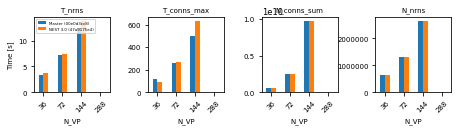

In [13]:
topology_m = pd.read_csv('results/topology_model_00e0d3cc8_daint.csv')
topology_m['Case'] = ['Master (00e0d3cc8)'] * len(topology_m)
topology_3 = pd.read_csv('results/topology_model_3_0_47a9175e4_daint.csv')
topology_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(topology_3)

topology = pd.concat([topology_m, topology_3])

#topology = calculate_T_conn_and_memory(topology)

topology['N_VP'] = topology['NUM_VPS']

topology_p = plot_compare(topology, 'figures/topology_model_weak_scaling.pdf',
                          values=['T_nrns','T_conns_max', 'N_conns_sum', 'N_nrns'],
                          plot_T_sim=False, legend_loc='upper left')

topology

### 4x4 Mesocircuit model

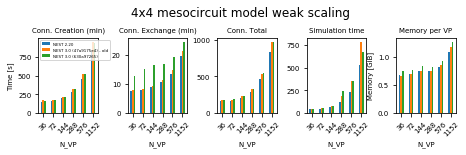

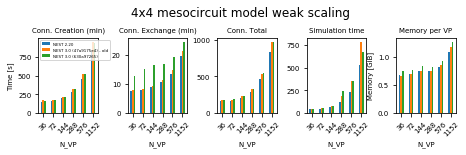

In [46]:
meso_2_20 = pd.read_csv('results/4x4_mesocircuit_2_20_37722d5e3_daint.csv')
meso_2_20['Case'] = ['NEST 2.20'] * len(meso_2_20)
meso_3 = pd.read_csv('results/4x4_mesocircuit_3_0_630a97265_daint.csv')
meso_3['Case'] = ['NEST 3.0 (630a97265)'] * len(meso_3)

meso_3_old = pd.read_csv('results/4x4_mesocircuit_3_0_47a9175e4_daint.csv')
meso_3_old['Case'] = ['NEST 3.0 (47a9175e4) - old'] * len(meso_3_old)

meso = pd.concat([meso_2_20, meso_3, meso_3_old])

meso = calculate_T_conn_and_memory(meso)
meso
meso_p = plot_compare(meso, 'figures/4x4_mesocircuit_weak_scaling.pdf',
                      #values=['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                      #        'N_conns_sum', 'N_nrns'],
                      legend_loc='upper left',
                      title='4x4 mesocircuit model weak scaling')

meso_p = plot_compare(meso, 'figures/4x4_mesocircuit_weak_scaling.svg',
                      legend_loc='upper left',
                      title='4x4 mesocircuit model weak scaling')

# print(meso['N_nrns'])
# print(meso['N_conns_sum'])

### IPPEN

In [9]:
def ippen_plot(df, name, values, legend_loc='upper right', title=''):
    
    fontsize = 10
    index = 'N_VP'
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    fig, axes = plt.subplots(nrows=len(values), ncols=1, figsize=(cm2inch(19),cm2inch(29)))
    if len(values) == 1:
        axes = [axes]

    for indx, val_name in enumerate(values):
        logy=False
        if val_name == 'Simulation Time [s]':
            logy=True
        if val_name == 'VSize_sum':
            df_p[val_name][::5].plot(kind='bar', ax = axes[indx],
                                fontsize=fontsize, logy=logy,
                                legend=False)
        else:
            df_p[val_name].plot(kind='line', style=['-*'] * len(df['Case']), ax = axes[indx],
                                fontsize=fontsize, logy=logy,
                                legend=False)
        axes[indx].set_ylabel(val_name, fontsize=fontsize)
    axes[0].legend(fontsize=fontsize, loc=legend_loc)
    
    axes[0].set_xlabel('')
    axes[1].set_xlabel('')
    axes[2].set_xlabel('')
    axes[3].set_xlabel('Virtual Processes', fontsize=fontsize)

    plt.subplots_adjust(wspace=0.5)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

Conn. Creation (min) [s]                                             \
Case      6ec58071f - threads NEST 2.20 - mpi NEST 3.0 (630a97265) - mpi   
N_VP                                                                       
1                       12.27           12.61                      13.20   
2                        7.01            6.57                       7.30   
3                        7.36            4.34                       4.94   
4                        6.46            3.27                       3.71   
5                        5.65             NaN                       2.97   
6                        4.89            2.24                       2.61   
7                        4.47            1.94                       2.26   
8                        4.02            1.76                       2.05   
9                        3.83            1.59                       1.81   
10                       3.52            1.48                       1.66   
11                       3.40            1.35                       1.54   
12                       3.30            1.24                       1.42   
13                       3.16            1.18                       1.33   
14                       2.94            1.13                       1.27   
15                       2.89            1.04                       1.20   
16                       2.76            1.00                       1.15   
17                       2.66            0.96                       1.08   
18                       2.54            0.89                       1.03   
19                       2.45            0.87                       0.98   
20                       2.35            0.81                       0.92   
21                       2.31            0.77                       0.88   
22                       2.21            0.74                       0.84   
23                       2.14            0.71                       0.80   
24                       2.08            0.67                       0.77   
25                       2.03            0.65                       0.74   
26                       1.95            0.63                       0.72   
27                       1.91            0.61                       0.70   
28                       1.86            0.57                       0.67   
29                       1.82            0.56                       0.65   
30                       1.75            0.54                       0.63   
31                       1.72            0.53                       0.60   
32                       1.66            0.51                       0.59   
33                       1.62            0.50                       0.57   
34                       1.58            0.49                       0.55   
35                       1.56            0.51                       0.54   
36                       1.52            0.45                       0.53   

     Conn. Exchange (min) [s]                                             \
Case      6ec58071f - threads NEST 2.20 - mpi NEST 3.0 (630a97265) - mpi   
N_VP                                                                       
1                       11.50           11.54                      11.60   
2                        6.83            5.72                       5.76   
3                        6.19            3.96                       3.92   
4                        5.58            2.98                       2.96   
5                        4.99             NaN                       2.46   
6                        4.66            2.10                       2.11   
7                        4.40            1.84                       1.85   
8                        4.16            1.61                       1.62   
9                        3.95            1.49                       1.50   
10                       3.83            1.37                       1.37   
11                       3.71            1.29       

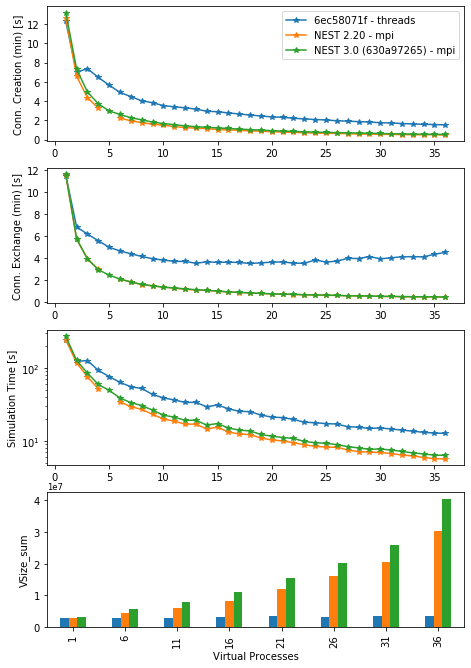

In [51]:
ippen_thread_220 = pd.read_csv('results/hpc_benchmark_2_20_daint_ippen_thread.csv')
ippen_mpi_220 = pd.read_csv('results/hpc_benchmark_2_20_daint_ippen_mpi.csv')
ippen_thread_220['Case'] = ['NEST 2.20 - threads'] * len(ippen_thread_220)
ippen_mpi_220['Case'] = ['NEST 2.20 - mpi'] * len(ippen_mpi_220)

ippen_thread_6ec58071f = pd.read_csv('results/hpc_benchmark_6ec58071f_daint_ippen_thread.csv')
ippen_thread_6ec58071f['Case'] = ['6ec58071f - threads'] * len(ippen_thread_6ec58071f)

ippen_thread_3 = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_ippen_thread.csv')
ippen_mpi_3 = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_ippen_mpi.csv')
ippen_thread_3['Case'] = ['NEST 3.0 (630a97265) - threads'] * len(ippen_thread_3)
ippen_mpi_3['Case'] = ['NEST 3.0 (630a97265) - mpi'] * len(ippen_mpi_3)

ippen = pd.concat([ippen_thread_220, ippen_mpi_220, ippen_thread_6ec58071f, ippen_thread_3, ippen_mpi_3])
ippen = pd.concat([ippen_mpi_220, ippen_thread_6ec58071f, ippen_mpi_3])

ippen['N_VP'] = ippen['NUMBER_OF_NODES'] * ippen['TASKS_PER_NODE'] * ippen['THREADS_PER_TASK']

ippen = calculate_T_conn_and_memory(ippen)

ippen['Simulation Time [s]'] = ippen['T_sim']
ippen['Conn. Exchange (min) [s]'] = ippen['T_ini_min']
ippen['Conn. Creation (min) [s]'] = ippen['T_conns_min']

ippen_p = ippen_plot(ippen, 'figures/ippen_benchmark.pdf',
                     values=['Conn. Creation (min) [s]', 'Conn. Exchange (min) [s]',
                             'Simulation Time [s]', 'VSize_sum'])

ippen_p

## Benchmarks with strong scaling

### HPC Benchmark

Conn. Creation (min)                     Conn. Exchange (min)  \
Case         Master (6d8d3047) NEST 3.0 (3aae0a19)    Master (6d8d3047)   
num_tasks                                                                 
1                         3.31                3.78                 3.16   
2                         1.86                1.92                 2.45   
4                         0.91                0.97                 0.95   
8                         0.46                0.49                 0.54   
16                        0.23                0.25                 0.30   
32                        0.11                0.12                 0.54   
64                        0.06                0.07                 0.38   
128                       0.03                0.04                 0.58   

                                    Conn. Total                      \
Case      NEST 3.0 (3aae0a19) Master (6d8d3047) NEST 3.0 (3aae0a19)   
num_tasks                                                             
1                        3.10              6.47                6.88   
2                        1.86              4.31                3.81   
4                        1.01              1.91                2.01   
8                        0.56              1.19                1.06   
16                       0.40              0.56                0.90   
32                       0.21              0.76                0.35   
64                       0.31              0.49                0.52   
128                      0.58              0.66                0.76   

            Simulation time                      
Case      Master (6d8d3047) NEST 3.0 (3aae0a19)  
num_tasks                                        
1                     39.65               40.08  
2                     35.90               18.50  
4                      9.02                9.22  
8                      5.14                4.41  
16                     2.52                2.45  
32                     3.46                2.21  
64                     3.05                2.55  
128                    3.59                3.04

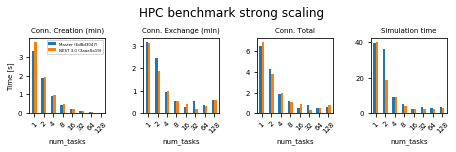

In [18]:
hpc_strong_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_strong_scaling.csv')
hpc_strong_m['Case'] = ['Master (6d8d3047)'] * len(hpc_strong_m)
hpc_strong_3 = pd.read_csv('results/hpc_benchmark_3_0_daint_strong_scaling.csv')
hpc_strong_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(hpc_strong_3)

hpc_strong = pd.concat([hpc_strong_m, hpc_strong_3])

hpc_strong = calculate_T_conn_and_memory(hpc_strong)
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']
hpc_strong_p = plot_compare(hpc_strong, 'figures/hpc_benchmark_strong_scaling.pdf', values=values, index='num_tasks',
                            legend_loc='upper right',
                            title='HPC benchmark strong scaling')

hpc_strong_p

### Population model

Conn. Creation (min)                      Conn. Exchange (min)  \
Case                 NEST 2.20 NEST 3.0 (630a97265)            NEST 2.20   
num_tasks                                                                  
6                    71.324164            57.804584            47.624212   
12                   50.129546            34.527905            23.524206   
24                   38.904915            22.543471            12.937575   
48                   33.418015            16.547482             7.872210   
96                   30.753708            13.520983             4.671457   
192                  29.517396            12.033568             2.990739   
384                  28.974048            11.228554             1.844977   
768                  27.407290            10.770785             1.190094   

                               Conn. Total                       \
Case      NEST 3.0 (630a97265)   NEST 2.20 NEST 3.0 (630a97265)   
num_tasks                                                         
6                    78.622077  123.471093           136.819173   
12                   38.825472   76.196952            73.655930   
24                   20.397037   53.271152            43.176714   
48                   11.679158   42.225837            28.733300   
96                    7.211241   36.140110            21.247847   
192                   4.538679   33.340712            17.204961   
384                   2.479983   31.634172            14.198042   
768                   1.414014   29.502074            12.899132   

          Memory per task                       
Case            NEST 2.20 NEST 3.0 (630a97265)  
num_tasks                                       
6               20.938893            21.202587  
12              11.013250            11.693613  
24               6.395530             6.945685  
48               3.788223             4.431476  
96               2.483136             3.305507  
192              1.937623             2.635014  
384              1.605255             2.291650  
768              1.349469             2.039092

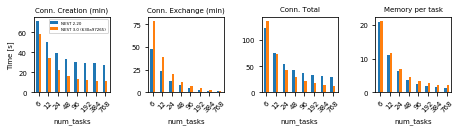

In [17]:
population_strong_220 = pd.read_csv('results/population_model_2_20_daint_strong_scaling_in.csv')
population_strong_220['Case'] = ['NEST 2.20'] * len(population_strong_220)
population_strong_3 = pd.read_csv('results/population_model_3_0_630a97265_daint_strong_scaling_in.csv')
population_strong_3['Case'] = ['NEST 3.0 (630a97265)'] * len(population_strong_3)

population_strong = pd.concat([population_strong_220, population_strong_3])

population_strong = calculate_T_conn_and_memory(population_strong)
population_strong['Memory per task'] = (population_strong['VSize_sum']/population_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
population_strong_p = plot_compare(population_strong, 'figures/population_model_strong_scaling.pdf', values=values,
                                   index='num_tasks', plot_T_sim=False, legend_loc='upper right',
                                   title='Population model strong sa')

population_strong_p

### Multi-Area Model

                            git  NUMBER_OF_NODES  TASKS_PER_NODE  NUM_VPS  \
0  GIT: (NEST nest-3@47a9175e4)               32               6      NaN   
1  GIT: (NEST nest-3@47a9175e4)               48               6      NaN   
2  GIT: (NEST nest-3@47a9175e4)               64               6      NaN   
3  GIT: (NEST nest-3@47a9175e4)               80               6      NaN   
4  GIT: (NEST nest-3@47a9175e4)               96               6      NaN   
5  GIT: (NEST nest-3@47a9175e4)              112               6      NaN   
6  GIT: (NEST nest-3@47a9175e4)              128               6      NaN   

   THREADS_PER_TASK  SCALE  NUM_VPS.1  num_tasks  T_network_local  \
0                 6      1        NaN        192        42.877114   
1                 6      1        NaN        288        35.433273   
2                 6      1        NaN        384        32.082029   
3                 6      1        NaN        480        30.123940   
4                 6      1        NaN 

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,Simulation time
Case,NEST 3.0 (47a9175e4),NEST 3.0 (47a9175e4),NEST 3.0 (47a9175e4),NEST 3.0 (47a9175e4)
num_tasks,,,,
192,77.340813,28.159943,105.502340,37.709824
288,69.712029,22.065063,91.779859,44.425755
384,66.715326,18.756371,85.472043,47.280171
480,63.418275,16.319383,79.740380,76.969127
576,63.423330,14.632541,78.058595,76.763005
672,59.374492,12.998581,72.375606,77.170446
768,58.556264,12.688724,71.247433,69.401331


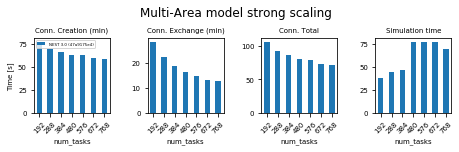

In [47]:
# MAM_strong_m = pd.read_csv('results/multi-area_model_6d8d3047_daint_strong_scaling_in.csv')
# MAM_strong_m['Case'] = ['Master (6d8d3047)'] * len(MAM_strong_m)
MAM_strong_3 = pd.read_csv('results/multi-area_model_3_0_47a9175e4_daint_strong_scaling.csv')
MAM_strong_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(MAM_strong_3)

MAM_strong = pd.concat([MAM_strong_3])

print(MAM_strong)

MAM_strong = calculate_T_conn_and_memory(MAM_strong)
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']
MAM_strong_p = plot_compare(MAM_strong, 'figures/multi-area_model_strong_scaling.pdf', values=values,
                            index='num_tasks', legend_loc='upper left',
                            title='Multi-Area model strong scaling')

MAM_strong_p

## Compare versions

### num. nodes = 1,  num. threads = {1,3,6,9,18,36}, num. vps=36

Conn. Creation (min)                                   \
Case                    2.14    2.16   2.18 Master (6d8d3047)   
threads                                                         
1                      36.44   21.73  17.62             17.42   
3                      47.89   38.73  30.85             30.24   
6                      52.17   51.38  42.25             41.48   
9                      53.47   58.84  43.85             42.44   
18                     54.55   81.97  56.37             56.02   
36                     61.78  124.92  74.22             74.35   

                            Conn. Exchange (min)                \
Case    NEST 3.0 (3aae0a19)                 2.14   2.16   2.18   
threads                                                          
1                     18.83                 0.62  18.79  11.87   
3                     32.47                 0.89  29.74  24.27   
6                     43.56                 0.96  35.99  32.64   
9                     46.28                 0.91  50.30  48.41   
18                    71.54                 1.38  66.25  68.98   
36                   108.66                 1.44  91.19  77.44   

                                                      ...          \
Case    Master (6d8d3047) NEST 3.0 (3aae0a19)         ...           
threads                                               ...           
1                   11.69               11.67         ...           
3                   24.48               23.32         ...           
6                   32.80               31.83         ...           
9                   45.36               45.06         ...           
18                  68.54               73.30         ...           
36                  77.49               77.72         ...           

        Memory per VP                                        \
Case             2.14      2.16      2.18 Master (6d8d3047)   
threads                                                       
1            2.312773  5.072531  3.096897          3.097431   
3            2.028328  4.422857  2.269574          2.295633   
6            1.983972  4.332034  2.121685          2.118519   
9            1.973401  4.311907  2.100494          2.067026   
18           1.963256  4.293865  2.008091          1.997216   
36           1.968212  4.284930  1.989075          1.989090   

                            Simulation time                                    \
Case    NEST 3.0 (3aae0a19)            2.14    2.16    2.18 Master (6d8d3047)   
threads                                                                         
1                  3.097244           85.58   87.81   92.16             89.93   
3                  2.308753          121.11  128.25  126.82            123.51   
6                  2.073484          128.85  131.90  134.71            133.43   
9                  2.098363          124.27  135.43  136.02            129.22   
18                 2.016601          130.37  137.20  137.85            135.70   
36                 2.018070          173.78  187.95  204.53            203.74   

                             
Case    NEST 3.0 (3aae0a19)  
threads                      
1                     98.86  
3                    131.22  
6                    137.56  
9                    135.80  
18                   139.79  
36                   210.48  

[6 rows x 25 columns]

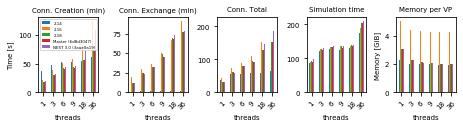

In [22]:
hpc_214 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_214_daint_threads_SCALE15.csv')
hpc_214['Case'] = ['NEST 2.14']*len(hpc_214)
hpc_216 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_216_daint_threads_SCALE15.csv')
hpc_216['Case'] = ['NEST 2.16']*len(hpc_216)
hpc_218 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_218_daint_threads_SCALE15.csv')
hpc_218['Case'] = ['NEST 2.18']*len(hpc_218)
hpc_220 = pd.read_csv('results/hpc_benchmark_220_daint_threads_s15.csv')
hpc_220['Case'] = ['NEST 2.20']*len(hpc_220)
hpc_3   = pd.read_csv('results/hpc_benchmark_3_0__630a97265_daint_threads_s15.csv')
hpc_3['Case']   = ['NEST 3.0 (630a97265)']*len(hpc_3)

hpc_versions = pd.concat([hpc_214, hpc_216, hpc_218, hpc_220, hpc_3])

hpc_versions = calculate_T_conn_and_memory(hpc_versions)
hpc_versions['threads'] = hpc_versions['THREADS_PER_TASK']
hpc_versions_p = plot_compare(hpc_versions, 'figures/hpc_different_versions.pdf', index='threads',
                              plot_T_sim=True, legend_loc='upper left',
                              rot=45)
hpc_versions_p

### num. threads = 1, num. nodes = {1, 2, 4, 8, 16, 32}, num. vps = 36

Conn. Creation (min)                                                      \
Case                 2.14   2.16   2.18 Master (6d8d3047) NEST 3.0 (3aae0a19)   
N_VP                                                                            
36                  35.65  21.84  17.56             17.53               18.82   
72                  37.68  21.74  17.36             17.18               19.03   
144                 39.38  21.71  17.38             17.33               18.97   
288                 40.99  22.01  17.39             17.20               19.15   
576                 42.90  21.77  17.39             17.23               19.44   
1152                43.87  21.73  17.37             17.12               20.17   

     Conn. Exchange (min)                                                      \
Case                 2.14   2.16   2.18 Master (6d8d3047) NEST 3.0 (3aae0a19)   
N_VP                                                                            
36                   0.60  18.22  11.78             11.96               11.71   
72                   0.63  18.84  11.78             11.91               12.04   
144                  0.58  22.50  12.36             12.13               12.12   
288                  0.67  22.05  13.03             13.41               13.53   
576                  0.90  24.56  15.09             15.27               15.39   
1152                 1.28  29.25  19.17             20.06               18.79   

             ...         Memory per VP                                        \
Case         ...                  2.14      2.16      2.18 Master (6d8d3047)   
N_VP         ...                                                               
36           ...              2.312611  5.072531  3.096897          3.097431   
72           ...              2.327074  5.073708  3.107514          3.108052   
144          ...              2.707514  5.075892  3.109698          3.110236   
288          ...              3.149024  5.080248  3.114054          3.114592   
576          ...              3.144015  5.108859  3.578192          3.578964   
1152         ...              3.161597  5.123802  4.092529          4.091714   

                         Simulation time                                    \
Case NEST 3.0 (3aae0a19)            2.14    2.16    2.18 Master (6d8d3047)   
N_VP                                                                         
36              3.097243           82.85   88.38   90.13             90.82   
72              3.107861           84.19   87.63   90.85             90.70   
144             3.110045           87.78   92.08   95.31             95.48   
288             3.114401           97.88  105.33  105.49            106.74   
576             3.577908          110.44  119.03  128.16            129.06   
1152            4.098217          140.54  163.31  172.90            176.92   

                          
Case NEST 3.0 (3aae0a19)  
N_VP                      
36                 97.74  
72                 97.94  
144               102.74  
288               114.11  
576               137.00  
1152              234.30  

[6 rows x 25 columns]

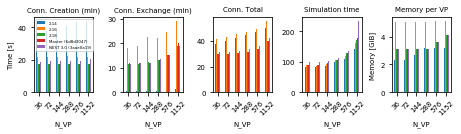

In [23]:
hpc_214_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214_t1['Case'] = ['NEST 2.14']*len(hpc_214_t1)
hpc_216_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216_t1['Case'] = ['NEST 2.16']*len(hpc_216_t1)
hpc_218_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218_t1['Case'] = ['NEST 2.18']*len(hpc_218_t1)
hpc_220_t1 = pd.read_csv('results/hpc_benchmar_220_daint_t1_s15.csv')
hpc_220_t1['Case']   = ['NEST 2.20']*len(hpc_220_t1)
hpc_3_t1   = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_t1_s15.csv')
hpc_3_t1['Case']   = ['NEST 3.0 (630a97265)']*len(hpc_3_t1)

hpc_versions_t1 = pd.concat([hpc_214_t1, hpc_216_t1, hpc_218_t1, hpc_m_t1, hpc_3_t1])

hpc_versions_t1 = calculate_T_conn_and_memory(hpc_versions_t1)
hpc_versions_t1_p = plot_compare(hpc_versions_t1, 'figures/hpc_different_versions_t1.pdf', legend_loc='upper left',
                                 rot=45)

hpc_versions_t1_p